## Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install langchain openai transformers --quiet
%pip install -U langchain-openai --quiet
%pip install torch torchvision torchaudio --quiet
%pip install -U langchain-community --quiet
%pip install ipywidgets --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.0/444.0 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.2 MB/s eta 0:00:00


In [ ]:
!pip install chromadb --quiet
!pip install open_clip_torch --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 106.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.8/510.8 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 117.6 MB/s eta 0

In [ ]:
import numpy as np
import re
import random
import os
import pandas as pd
from PIL import Image as PILImage
from PIL import Image, ImageEnhance, ImageFilter
from transformers import CLIPProcessor, CLIPModel
import torch
from langchain.agents import initialize_agent
from langchain_openai import ChatOpenAI
from langchain.tools import BaseTool
import chromadb
import base64
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
from chromadb.utils.data_loaders import ImageLoader
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Indexing

### set up the packages

In [ ]:
# Set the OpenAI API key
os.environ["OPENAI_API_KEY"] = "your_api_key_here" # put in your own API key here

# Initialise ChatGPT
# different models available
gpt4o = ChatOpenAI(temperature=0, model_name="gpt-4o")
gpt35 = ChatOpenAI(model="gpt-3.5-turbo")
gpt4om = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")

llm = gpt4o


In [ ]:
# Initialise CLIP model and processor
clip_model_name = "openai/clip-vit-base-patch32"
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)
clip_model = CLIPModel.from_pretrained(clip_model_name)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [ ]:
# Initialise the ChromaDB client
chroma_client = chromadb.PersistentClient(path="/path/to/your/folder") # put in your current working directory

# Initialise ChromaDB Image Loader
image_loader = ImageLoader()
image_loader._PILImage = PILImage

# Initialize CLIP embedding
CLIP = OpenCLIPEmbeddingFunction()

# Create a database of image vectors
image_vdb = chroma_client.get_or_create_collection(name="image", embedding_function=CLIP, data_loader=image_loader)

open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [ ]:
# Image Preprocessing Functions: to increse the visibility/quality of the images
def preprocess_image(image_path):
    image = PILImage.open(image_path).convert('RGB')

    # Resizing images
    image = image.resize((224, 224))

    # Enhanced contrast
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(2)

    # Denoising
    image = image.filter(ImageFilter.MedianFilter(size=3))

    return image

In [ ]:
# Clear the vector database and recreate the collection.
def clear_vdb():
    # Delete the existing collection
    chroma_client.delete_collection(name="image")

    # Recreate the collection
    global image_vdb
    image_vdb = chroma_client.get_or_create_collection(
        name="image",
        embedding_function=CLIP,
        data_loader=image_loader
    )

    return

### set up the dataset



In [ ]:
# create splits of the whole dataset
# the portion of the whole dataset is used as the variable
random_seed = 42
random.seed(random_seed)

dataset_path = r'/path/to/your/dataset' # put in your local path to the dataset
paths_dict = {}

# Walk through the directory and its subdirectories
for dirpath, _, filenames in os.walk(dataset_path):
    # Get the name of the subdirectory (last part of the path)
    subdir_name = os.path.basename(dirpath)

    # Collect all file paths in the current subdirectory
    file_paths = [os.path.join(dirpath, filename) for filename in filenames]

    # Add to dictionary if there are files in the subdirectory
    if file_paths:
        paths_dict[subdir_name] = file_paths

# List of dictionaries to store each split
split_dictionaries = [{} for _ in range(10)]

# Split each subdirectory's paths into 10 parts and save into 10 dictionaries
for subdir, paths in paths_dict.items():
    # Shuffle paths to ensure randomness
    random.shuffle(paths)

    # Calculate split size
    split_size = max(1, len(paths) // 10)  # Ensure each split gets at least one path

    # Split paths into 10 parts
    splits = [paths[i * split_size:(i + 1) * split_size] for i in range(10)]

    # Add each split to the corresponding dictionary
    for i, split in enumerate(splits):
        split_dictionaries[i][subdir] = split

### index and save functions

In [ ]:
# extract features
def extract_all_features(image_path, text):
    # Pre-processed images
    image_object = preprocess_image(image_path)

    # Image feature extraction using CLIP model
    clip_image_inputs = clip_processor(images=image_object, return_tensors="pt")
    clip_text_inputs = clip_processor(text=[text], return_tensors="pt")

    with torch.no_grad():
        clip_image_outputs = clip_model.get_image_features(**clip_image_inputs)
        clip_text_outputs = clip_model.get_text_features(**clip_text_inputs)

    # Normalize the features to have unit norm
    clip_image_outputs = torch.nn.functional.normalize(clip_image_outputs, p=2, dim=-1)
    clip_text_outputs = torch.nn.functional.normalize(clip_text_outputs, p=2, dim=-1)

    # Combine image and text features
    combined_features = (clip_image_outputs + clip_text_outputs) / 2

    # Spreading feature vectors into a one-dimensional list
    #image_features = combined_features.flatten().tolist()
    image_embedding = clip_image_outputs.flatten().tolist()
    text_embedding = clip_text_outputs.flatten().tolist()
    combined_feature = combined_features.flatten().tolist()
    return image_embedding, text_embedding, combined_feature



# extract features and save them locally
def extract_and_save_locally(save_path, directory_paths, max_images_per_folder):
    ids = []
    uris = []
    embeddings = []
    image_embeddings = []
    text_embeddings = []
    global_id = 0

    for directory_path in directory_paths:
        images_processed = 0
        # Iterate through files in the directory
        for filename in sorted(os.listdir(directory_path)):
            if filename.lower().endswith('.jpg'):
                if re.search(r'\(\d+\)', filename):
                    continue

                file_path = os.path.join(directory_path, filename)
                text = os.path.basename(os.path.dirname(file_path))
                print(f"Extracted text for {file_path}: {text}")
                #image_features = extract_image_features(file_path, text)
                image_feature, text_feature, combined_feature = extract_all_features(file_path, text)

                # Append image information to respective lists
                ids.append(str(global_id))
                uris.append(file_path)
                embeddings.append(combined_feature)
                image_embeddings.append(image_feature)
                text_embeddings.append(text_feature)
                global_id += 1
                images_processed += 1

                # Stop processing if max images per folder limit is reached
                if images_processed >= max_images_per_folder:
                    break

    np.savez(save_path, ids = ids, uris = uris, embeddings = embeddings, image_embeddings = image_embeddings, text_embeddings = text_embeddings)

    return



# extract features and save them locally
def extract_and_save_locally_withsplit(save_path, directory_paths):
    ids = []
    uris = []
    embeddings = []
    image_embeddings = []
    text_embeddings = []
    global_id = 0

    for key in directory_paths.keys():
        for file_path in directory_paths[key]:
            text = os.path.basename(os.path.dirname(file_path))
            print(f"Extracted text for {file_path}: {text}")
            #image_features = extract_image_features(file_path, text)
            image_feature, text_feature, combined_feature = extract_all_features(file_path, text)

            # Append image information to respective lists
            ids.append(str(global_id))
            uris.append(file_path)
            embeddings.append(combined_feature)
            image_embeddings.append(image_feature)
            text_embeddings.append(text_feature)
            global_id += 1
            #images_processed += 1

    np.savez(save_path, ids = ids, uris = uris, embeddings = embeddings, image_embeddings = image_embeddings, text_embeddings = text_embeddings)

    return

### *extract and save locally

#### execution with splits

In [ ]:
# use splits of the whole dataset


no_part_per_class = '10%'

path1 = '/path/to/save/datasets' # put in the directory where you want to save the extracted features
exp_name = f'vectorstore_{no_part_per_class}perClass'
npz_name = '.npz'
save_path = os.path.join(path1, exp_name + npz_name)


### 1st time: extract features and save locally for the first time of using this dataset
extract_and_save_locally_withsplit(save_path, split_dictionaries[0])

### construct the vectorstore

In [ ]:
# Add images from specified directories to the vector database.
def add_images_to_vdb3(feature_path, feature_used = 'embeddings'):
    """
    this function is created to make the type of features used in vectorstore a variable
    """

    data = np.load(feature_path)
    ids = data['ids'].tolist()
    uris = data['uris'].tolist()
    if feature_used == 'embeddings':
        embeddings = data['embeddings']
    elif feature_used == 'image_embeddings':
        embeddings = data['image_embeddings']
    elif feature_used == 'text_embeddings':
        embeddings = data['text_embeddings']

    print(len(ids))
    print(len(uris))
    print(len(embeddings))


    # Add all images to the database at once
    if len(ids)!= 0:
        image_vdb.add(ids=ids, uris=uris, embeddings=embeddings)
        print(f"Added {len(ids)} images to the database.")

    return


#### execution with splits

In [ ]:
# use splits of the whole dataset

exp_no_part_per_class = '10%'
path1 = '/path/to/the/saved/datasets' # put in the path to the saved features
exp_name = f'vectorstore_{exp_no_part_per_class}perClass'
npz_name = '.npz'
feature_path = os.path.join(path1, exp_name + npz_name)


# Clear the vector database before adding new images
clear_vdb()

# collect the extracted features from google drive and construct the vectorstore
add_images_to_vdb3(feature_path, feature_used = 'image_embeddings')


# Print the total count of images in the vector database
print("Image count in VDB:", image_vdb.count())

4337
4337
4337
Added 4337 images to the database.
Image count in VDB: 4337


## Retrieval

In [ ]:
# extract features for the query, only image data, no text data
def extract_query_features(image_path):
    # Pre-processed images
    image_object = preprocess_image(image_path)

    # Image feature extraction using CLIP model
    clip_image_inputs = clip_processor(images=image_object, return_tensors="pt")

    with torch.no_grad():
        clip_image_outputs = clip_model.get_image_features(**clip_image_inputs)


    # Normalize the features to have unit norm
    clip_image_outputs = torch.nn.functional.normalize(clip_image_outputs, p=2, dim=-1)


    image_embedding = clip_image_outputs.flatten().tolist()

    return image_embedding

In [ ]:
# Retrieve the vector database for similar images.
def query_db1(image_path, text, results=3, top_k=500):
    # the top-k here is not useful
    query_features = extract_query_features(image_path)
    try:
        all_results = image_vdb.query(

            query_embeddings=[query_features],
            n_results=image_vdb.count(),
            include=['uris', 'distances']
        )
    except Exception as e:
        print(f"Error querying the database: {e}")
        return None

    # Filter results
    filtered_results = filter_results1(all_results, image_path, top_k=results)

    return filtered_results


# Filter and sort the retrieved results.
def filter_results1(all_results, image_path, top_k):

    # Combined query results
    distances_and_uris_and_ids = list(zip(all_results['distances'][0], all_results['uris'][0], all_results['ids'][0]))

    organised_results = [(dist, uri, id) for dist, uri, id in distances_and_uris_and_ids]


    # Sort results
    sorted_results = sorted(organised_results, key=lambda x: x[0])


    # Select top_k results
    final_results = sorted_results[:top_k]


    # Separate results
    sorted_distances = [dist for dist, _, _ in final_results]
    sorted_uris = [uri for _, uri, _ in final_results]
    sorted_ids = [id for _, _, id in final_results]


    # return results
    return {
        'ids': [sorted_ids],
        'uris': [sorted_uris],
        'distances': [sorted_distances]
    }

## Generation

In [ ]:
# Define the image prompt template for CoT
image_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a mechanical engineer with expertise in manufacturing processes.
    You will be provided with an image of the target mechanical part,
    along with images and manufacutring process descriptions of similar parts to the target part.
    Your job is to use the images and manufacturing processes of the similar parts to describe the target part.
    """),

    ("user", [
        {"type": "text", "text": """The tartget mechanical part is shown in the image."""},
        {"type": "image_url", "image_url": "data:image/jpeg;base64,{image_query}"},
        {"type": "text", "text": """There are images and manufacturing processes of similar mechanical parts to the target part."""},
        {"type": "image_url", "image_url": "data:image/jpeg;base64,{retrieved_info_images_0}"},
        {"type": "image_url", "image_url": "data:image/jpeg;base64,{retrieved_info_images_1}"},
        {"type": "image_url", "image_url": "data:image/jpeg;base64,{retrieved_info_images_2}"},
        {"type": "text", "text": """they are individually manufacuted with the processes of"""},
        {"type": "text", "text": "{retrieved_info_texts}"},
        {"type": "text", "text": """Analyse the target part and the similar parts following the process:
        1. Step 1: Visual inspection for every part:
            a. Observe the shape in the image, focus on the geometric features.
        2. Step 2: Manufacturing method analysis for every part:
            a. Identify features that strongly indicate specific manufacutring methods.
            b. Also list other manufacutring methods possiblely related to the part based on the observations.
        3. Step 3: Comparison between the target part and the similar parts:
            a. Compare the target part and the similar parts based on the outputs from Step 1 and Step 2.
               If the target part and the similar parts are very alike, then the manufacturing process description of the target part should be
               similar to the ones of the similar parts.
               If the target part and the similar parts are not alike, then describe the manufacturing process of the target part independently.
        4. Step 4: Summary of the conclusion:
            a. If from the previous steps the target part is likely to be manufactured by a sheet metal/fabricated/forged/turned manufacturing process,
               go ahead and output the conclusion.
               If from the previous steps the target part is unlikely to be manufactured by a sheet metal/fabricated/forged/turned manufacturing process,
               categorise it as being manufactured by other manufacturing processes and output the conclusion.

        """},
        {"type": "text", "text": """Respond with a concise answer stating the manufacutring process used to produce the target part"""},
    ]),
])




# Define the image prompt template for 'hint for other'
image_prompt1 = ChatPromptTemplate.from_messages([
    ("system", """You are a mechanical engineer with expertise in manufacturing processes.
    You will be provided with an image of the target mechanical part,
    along with images and manufacutring process descriptions of similar parts to the target part.
    Your job is to use the images and manufacturing processes of the similar parts to describe the target part.
    """),

    ("user", [
        {"type": "text", "text": """The tartget mechanical part is shown in the image."""},
        {"type": "image_url", "image_url": "data:image/jpeg;base64,{image_query}"},
        {"type": "text", "text": """There are images and manufacturing processes of similar mechanical parts to the target part."""},
        {"type": "image_url", "image_url": "data:image/jpeg;base64,{retrieved_info_images_0}"},
        {"type": "image_url", "image_url": "data:image/jpeg;base64,{retrieved_info_images_1}"},
        {"type": "image_url", "image_url": "data:image/jpeg;base64,{retrieved_info_images_2}"},
        {"type": "text", "text": """they are individually manufacuted with the processes of"""},
        {"type": "text", "text": "{retrieved_info_texts}"},
        {"type": "text", "text": """Respond with a concise answer stating the manufacutring process used to produce the target part"""},
        {"type": "text", "text": """If from the previous steps the target part is likely to be manufactured by a sheet metal/fabricated/forged/turned manufacturing process, go ahead and output the conclusion.
               If from the previous steps the target part is unlikely to be manufactured by a sheet metal/fabricated/forged/turned manufacturing process, categorise it as being manufactured by other manufacturing processes and output the conclusion."""},

    ]),
])



# prompt template for no RAG
image_prompt2 = ChatPromptTemplate.from_messages([
    ("system", """You are a mechanical engineer with expertise in manufacturing processes.
    You will be provided with an image of the target mechanical part,
    Your job is to use the images and manufacturing processes of the similar parts to describe the target part.
    """),

    ("user", [
        {"type": "text", "text": """The tartget mechanical part is shown in the image."""},
        {"type": "image_url", "image_url": "data:image/jpeg;base64,{image_query}"},

    ]),
])



# Initialise the output parser
parser = StrOutputParser()


# Define the LangChain chain
vision_chain = image_prompt | llm | parser
vision_chain1 = image_prompt1 | llm | parser
vision_chain2 = image_prompt2 | llm | parser

In [ ]:
# Format the inputs for the prompt template
def format_prompt_inputs(data, user_query, query_path):
    inputs = {}

    with open(query_path, 'rb') as image_file:
        image_query = image_file.read()
    inputs['image_query'] = base64.b64encode(image_query).decode('utf-8')


    # Extract and include retrieved text information
    retrieved_texts = [os.path.basename(os.path.dirname(uri)) for uri in data['uris'][0]]
    inputs['retrieved_info_texts'] = ', '.join(retrieved_texts)


    # Coding retrieved images
    for i, uri in enumerate(data['uris'][0][:3]):
        with open(uri, 'rb') as image_file:
            inputs[f'retrieved_info_images_{i}'] = base64.b64encode(image_file.read()).decode('utf-8')

    # If fewer than 3 images are retrieved, fill with an empty string
    for i in range(len(data['uris'][0]), 3):
        inputs[f'retrieved_info_images_{i}'] = ''


    return inputs



# Generate a description of an image using RAG
def generate_description_with_rag1(image_path, prompting=0):
    try:
        #text_info = os.path.basename(os.path.dirname(image_path))
        text_fill = '' # not useful in the function, just a placefiller for consistencies of function callings
        user_query = "Analyze the mechanical component image with reference to similar components." # this uver query is actually not used in the prompt
        results = query_db1(image_path, text_fill, results=3)
        print(f"Query part is: {os.path.basename(image_path)}")
        #print(f"Query part is: {image_path}")
        #print(f"Retrievals: {results}")        # used to track files retrived

        if results is None or len(results['uris'][0]) == 0:
            print(f"Warning: No results retrieved for {image_path}")
            return "Unable to generate description due to lack of similar components."

        prompt_input = format_prompt_inputs(results, user_query, image_path)

        if prompting == 0: # CoT
            response = vision_chain.invoke(prompt_input)
        elif prompting == 1: # simple prompting
            response = vision_chain1.invoke(prompt_input)
        else:
            response = vision_chain2.invoke(prompt_input)
        #print(f"Generations: {response}")
        print("------------------------------------------------------------")
        return response
    except Exception as e:
        print(f"Error in generate_description_with_rag for {image_path}: {str(e)}")
        print("*************************************************************")
        return f"Error generating description: {str(e)}"


### Generation examples

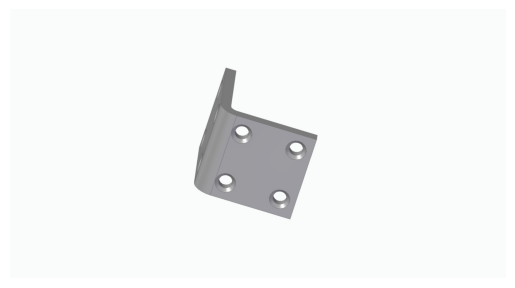

Query part is: Sheet Metal_1.jpg
------------------------------------------------------------
The part shown in the image is an L-shaped bracket with four holes. Here's a description and potential manufacturing process:

### Description:
- **Shape**: L-shaped bracket.
- **Features**: 
  - Two perpendicular flat surfaces.
  - Four holes, likely for mounting or fastening.
  - Rounded edges for added strength and safety.

### Manufacturing Process:
1. **Material Selection**: Typically made from metal (steel, aluminum) for strength and durability.

2. **Cutting**: 
   - Start with a flat sheet of metal.
   - Use laser cutting or CNC machining to cut the initial shape and holes.

3. **Bending**: 
   - Use a press brake to bend the metal into the L-shape.

4. **Drilling**: 
   - Ensure holes are precisely drilled if not done during the cutting process.

5. **Finishing**: 
   - Deburr edges to remove sharpness.
   - Apply surface treatment (e.g., powder coating, anodizing) for corrosion resis

In [ ]:
"""
no rag generation
"""

img1 = '/path/to/the/dataset/5_Classes/Sheet Metal/Sheet Metal_1.jpg' # put in the path to one example in the dataset
img_dis = mpimg.imread(img1)

plt.imshow(img_dis)
plt.axis("off")
plt.show()
description = generate_description_with_rag1(img1, prompting=2)
print(description)

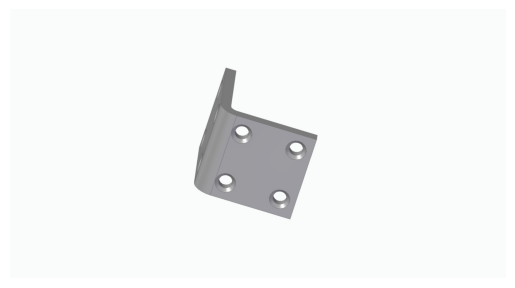

Query part is: Sheet Metal_1.jpg
------------------------------------------------------------
The target part is likely manufactured using a sheet metal process.


In [ ]:
"""
simple prompting generation
"""

img1 = '/path/to/the/dataset/5_Classes/Sheet Metal/Sheet Metal_1.jpg' # put in the path to one example in the dataset
img_dis = mpimg.imread(img1)

plt.imshow(img_dis)
plt.axis("off")
plt.show()
description = generate_description_with_rag1(img1, prompting=1)
print(description)

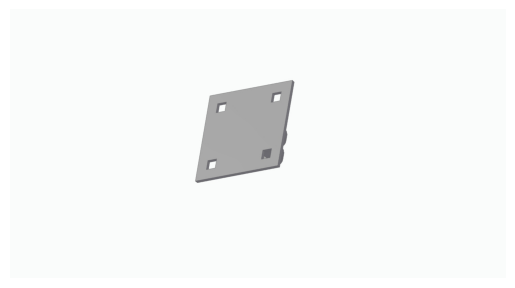

Query part is: Fabricated_262.jpg
------------------------------------------------------------
The target part is likely manufactured by a fabricated process.


In [ ]:
"""
simple prompting generation
"""

img1 = '/path/to/the/dataset/5_Classes/Fabricated/Fabricated_262.jpg' # put in the path to one example in the dataset
img_dis = mpimg.imread(img1)

plt.imshow(img_dis)
plt.axis("off")
plt.show()
description = generate_description_with_rag1(img1, prompting=1)
print(description)

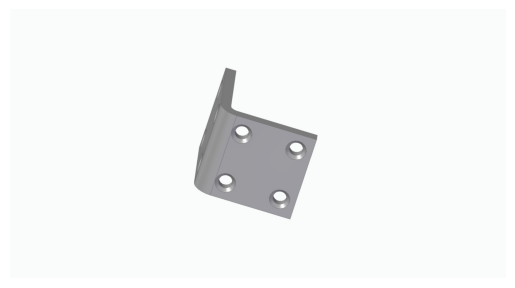

Query part is: Sheet Metal_1.jpg
------------------------------------------------------------
Step 1: Visual Inspection

- **Target Part**: The part has an L-shaped bracket with four holes on one face.
- **Similar Parts**: All have an L-shaped bracket with four holes on one face.

Step 2: Manufacturing Method Analysis

- **Target Part**: The flat surfaces, bends, and holes suggest sheet metal fabrication.
- **Similar Parts**: Also indicate sheet metal fabrication due to similar features.

Step 3: Comparison

- The target part and similar parts are very alike in shape and features, indicating a similar manufacturing process.

Step 4: Summary of the Conclusion

- The target part is likely manufactured using a sheet metal process, similar to the similar parts.


In [ ]:
"""
CoT generation
"""

img1 = '/path/to/the/dataset/5_Classes/Sheet Metal/Sheet Metal_1.jpg' # put in the path to one example in the dataset
img_dis = mpimg.imread(img1)

plt.imshow(img_dis)
plt.axis("off")
plt.show()
description = generate_description_with_rag1(img1, prompting=0)
print(description)